This notebook uses Azure Cognitive Services to transcribe text on an old map.
It then puts the text with its geographic location into a shapefile.
A blog post about it is here: http://jeffblackadar.ca/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
# !apt-get install libgeos-3.6.2 (I am not sure if this is needed)
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install geopandas
!pip install contextily
!pip install -U rasterio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
     / 129.7 MB 82 kB/s
ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 533 kB/s 
     |████████████████████████████████| 6.3 MB 40.7 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [3]:
!pip install --upgrade azure-cognitiveservices-vision-computervision

     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 41 kB 580 kB/s 


In [4]:
settings_path = "/content/drive/MyDrive/william_white/"
map_base_dir = '/content/drive/MyDrive/bsr/ta-map-150-iii-so/'
    
import os
import json
# Set the file we wan!pip install --upgrade azure-cognitiveservices-vision-computervisiont to use for authenticating an Azure app
# The json file stores the COMPUTER_VISION_SUBSCRIPTION_KEY and COMPUTER_VISION_ENDPOINT so we don't have it in the code.
# The json file looks like this:
# {
# "COMPUTER_VISION_SUBSCRIPTION_KEY":"___the_COMPUTER_VISION_SUBSCRIPTION_KEY___",
# "COMPUTER_VISION_ENDPOINT":"___the_COMPUTER_VISION_ENDPOINT___"
# }
# cv.json contains the credentials for this program.
cv_settings_file = settings_path+'cv.json'
with open(cv_settings_file, "r") as read_file:
    cv_auth_data = json.load(read_file)

os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']=cv_auth_data["COMPUTER_VISION_SUBSCRIPTION_KEY"]
os.environ['COMPUTER_VISION_ENDPOINT']=cv_auth_data["COMPUTER_VISION_ENDPOINT"]

In [5]:
# https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/python-sdk
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import pandas as pd
import contextily as ctx

In [6]:
# Add your Computer Vision subscription key to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()
# Add your Computer Vision endpoint to your environment variables.
if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
else:
    print("\nSet the COMPUTER_VISION_ENDPOINT environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()

In [7]:
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

# Set this up for a series of images

In [8]:
import math
def recognize_text_in_local_image(local_image_handwritten_path):
    local_image_handwritten = open(local_image_handwritten_path, "rb")
    # Call API with image and raw response (allows you to get the operation location)
    recognize_handwriting_results = computervision_client.read_in_stream(local_image_handwritten, raw=True, language='fr')

    # Get the operation location (URL with an ID at the end) from the response
    operation_location_remote = recognize_handwriting_results.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = operation_location_remote.split("/")[-1]

    # Call the "GET" API and wait for it to retrieve the results 
    while True:
        get_handw_text_results = computervision_client.get_read_result(operation_id)
        if get_handw_text_results.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    # Print the detected text, line by line
    lines_of_text = []
    if get_handw_text_results.status == OperationStatusCodes.succeeded:
        for text_result in get_handw_text_results.analyze_result.read_results:
            for line in text_result.lines:
                line_data = []  
                #print(line.text)
                line_data.append(line.text)
                #print(line.bounding_box)
                line_data.append(line.bounding_box)
                pts = line_data[1]
                xd = abs(pts[4] - pts[0])
                yd = abs(pts[5] - pts[1])
                word_length = math.sqrt((xd ** 2) + (yd ** 2))
            
                letter_length = round(word_length/len(line.text))
                print(line.text +"  "+str(letter_length))
                line_data.append(letter_length)
                lines_of_text.append(line_data)
    return(lines_of_text)          


In [9]:
import cv2
import matplotlib.pyplot as plt
import gdal
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1
fontColor              = (0,0,200)
fontColor_small        = (200,0,0)
lineType               = 2

def get_point_from_pixel(x,y, xoffset, px_w, rot1, yoffset, px_h, rot2):
    # supposing x and y are your pixel coordinate this 
    # is how to get the coordinate in space.
    posX = px_w * x + rot1 * y + xoffset
    posY = rot2 * x + px_h * y + yoffset

    posX = (px_w * x) + (rot1 * y) + xoffset
    posY = (px_h * y) + (rot2 * x) + yoffset
    # shift to the center of the pixel
    posX += px_w / 2.0
    posY += px_h / 2.0
    return(posX,posY)

def geocode_labels(local_image_handwritten_path, lines_of_text):
    img = cv2.imread(local_image_handwritten_path)
    img_ds = gdal.Open(local_image_handwritten_path)
    xoffset, px_w, rot1, yoffset, rot2, px_h  = img_ds.GetGeoTransform()

    line_text_poly = gpd.GeoDataFrame()
    line_text_poly['geometry'] = None
    #geotif_crs = 32128
    #geotif_crs = 32637 DAMAS
    geotif_crs = 32129 #PA South
    #geotif_crs = 4326
    line_text_poly.crs = ("EPSG:" + str(geotif_crs))
    line_text_poly.geometry = line_text_poly.geometry.to_crs(crs=geotif_crs)
    line_text_poly.to_crs(crs=geotif_crs)
    line_text_poly = line_text_poly.to_crs(epsg=geotif_crs)
   
    ln = 0
    for l in lines_of_text:
        pts = l[1]
        letter_size = l[2]
        fColor = fontColor
        if(letter_size < 90):
  
            p=[]
            for cn in range(0,4):
                p.append(get_point_from_pixel(pts[0+(cn*2)],pts[1+(cn*2)], xoffset, px_w, rot1, yoffset, px_h, rot2))
            coords = [(p[0][0], p[0][1]), (p[1][0], p[1][1]), (p[2][0], p[2][1]), (p[3][0], p[3][1])]
    
            poly = Polygon(coords)
            new_tp_row = {'id':ln, 'geometry':poly,'text':l[0]}
            line_text_poly = line_text_poly.append(new_tp_row, ignore_index=True)
    
    return(line_text_poly)

In [12]:
tiles = []

In [13]:
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c08.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r01c08.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r02c08.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r03c08.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r04c08.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r05c08.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c00.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c01.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c02.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c03.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c04.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c05.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c06.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c07.tif')
        tiles.append('/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r06c08.tif')

In [14]:

all_line_text_poly = gpd.GeoDataFrame()
all_line_text_poly['geometry'] = None
geotif_crs = 4806
#geotif_crs = 4326
all_line_text_poly.crs = ("EPSG:" + str(geotif_crs))
all_line_text_poly.geometry = all_line_text_poly.geometry.to_crs(crs=geotif_crs)
all_line_text_poly.to_crs(crs=geotif_crs)
all_line_text_poly = all_line_text_poly.to_crs(epsg=geotif_crs)

for t in tiles:
    print(t)  
    lines_of_text = recognize_text_in_local_image(t)
    temp_df = geocode_labels(t,lines_of_text)
    all_line_text_poly = gpd.GeoDataFrame(pd.concat([all_line_text_poly,temp_df], ignore_index=True), crs=all_line_text_poly.crs)

all_line_text_poly.to_file(os.path.join(map_base_dir,"all_line_text.shp"))

/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c00.tif
F  88
8 heals of  21
cable ricardo  25
Fontk  30
Porile  19
/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c01.tif
Wall frot  26
F. 150 della Carta d'  40
Nelly Sch 1. 79  36
heales of a road Decuid La Torretta ou Deci  23
Oto  24
Cisterhole  29
( Lungo  31
Trigoria  28
Contle  18
95 & Las  16
fella Macchia  27
/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c02.tif
ta  39
d'Italia  45
Four W. Ckou  31
Nores nous  39
79  46
à di Deci  20
zu0  29
Castel Romano - Capoco  31
Pratica / huit betr. CR au  25
Que Maggiara  28
/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c03.tif
CASTEL  112
Pavement of road  18
pist before route migliore  16
Capocotta  27
Dist tac Pour Ache TI, 550  14
Longitudine dal meridi  26
. CR and Pratica)  23
Torraccio  15
K,16  18
Fontanile  20
Mello Schizzare  28
Rudefl  23
/content/drive/MyDrive/bsr/ta-map-150-iii-so/tif_tiles/r00c04.tif
ROMANO  112
At astrous  33
Tow

epsg:4806
epsg:4806


/usr/local/lib/python3.7/dist-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


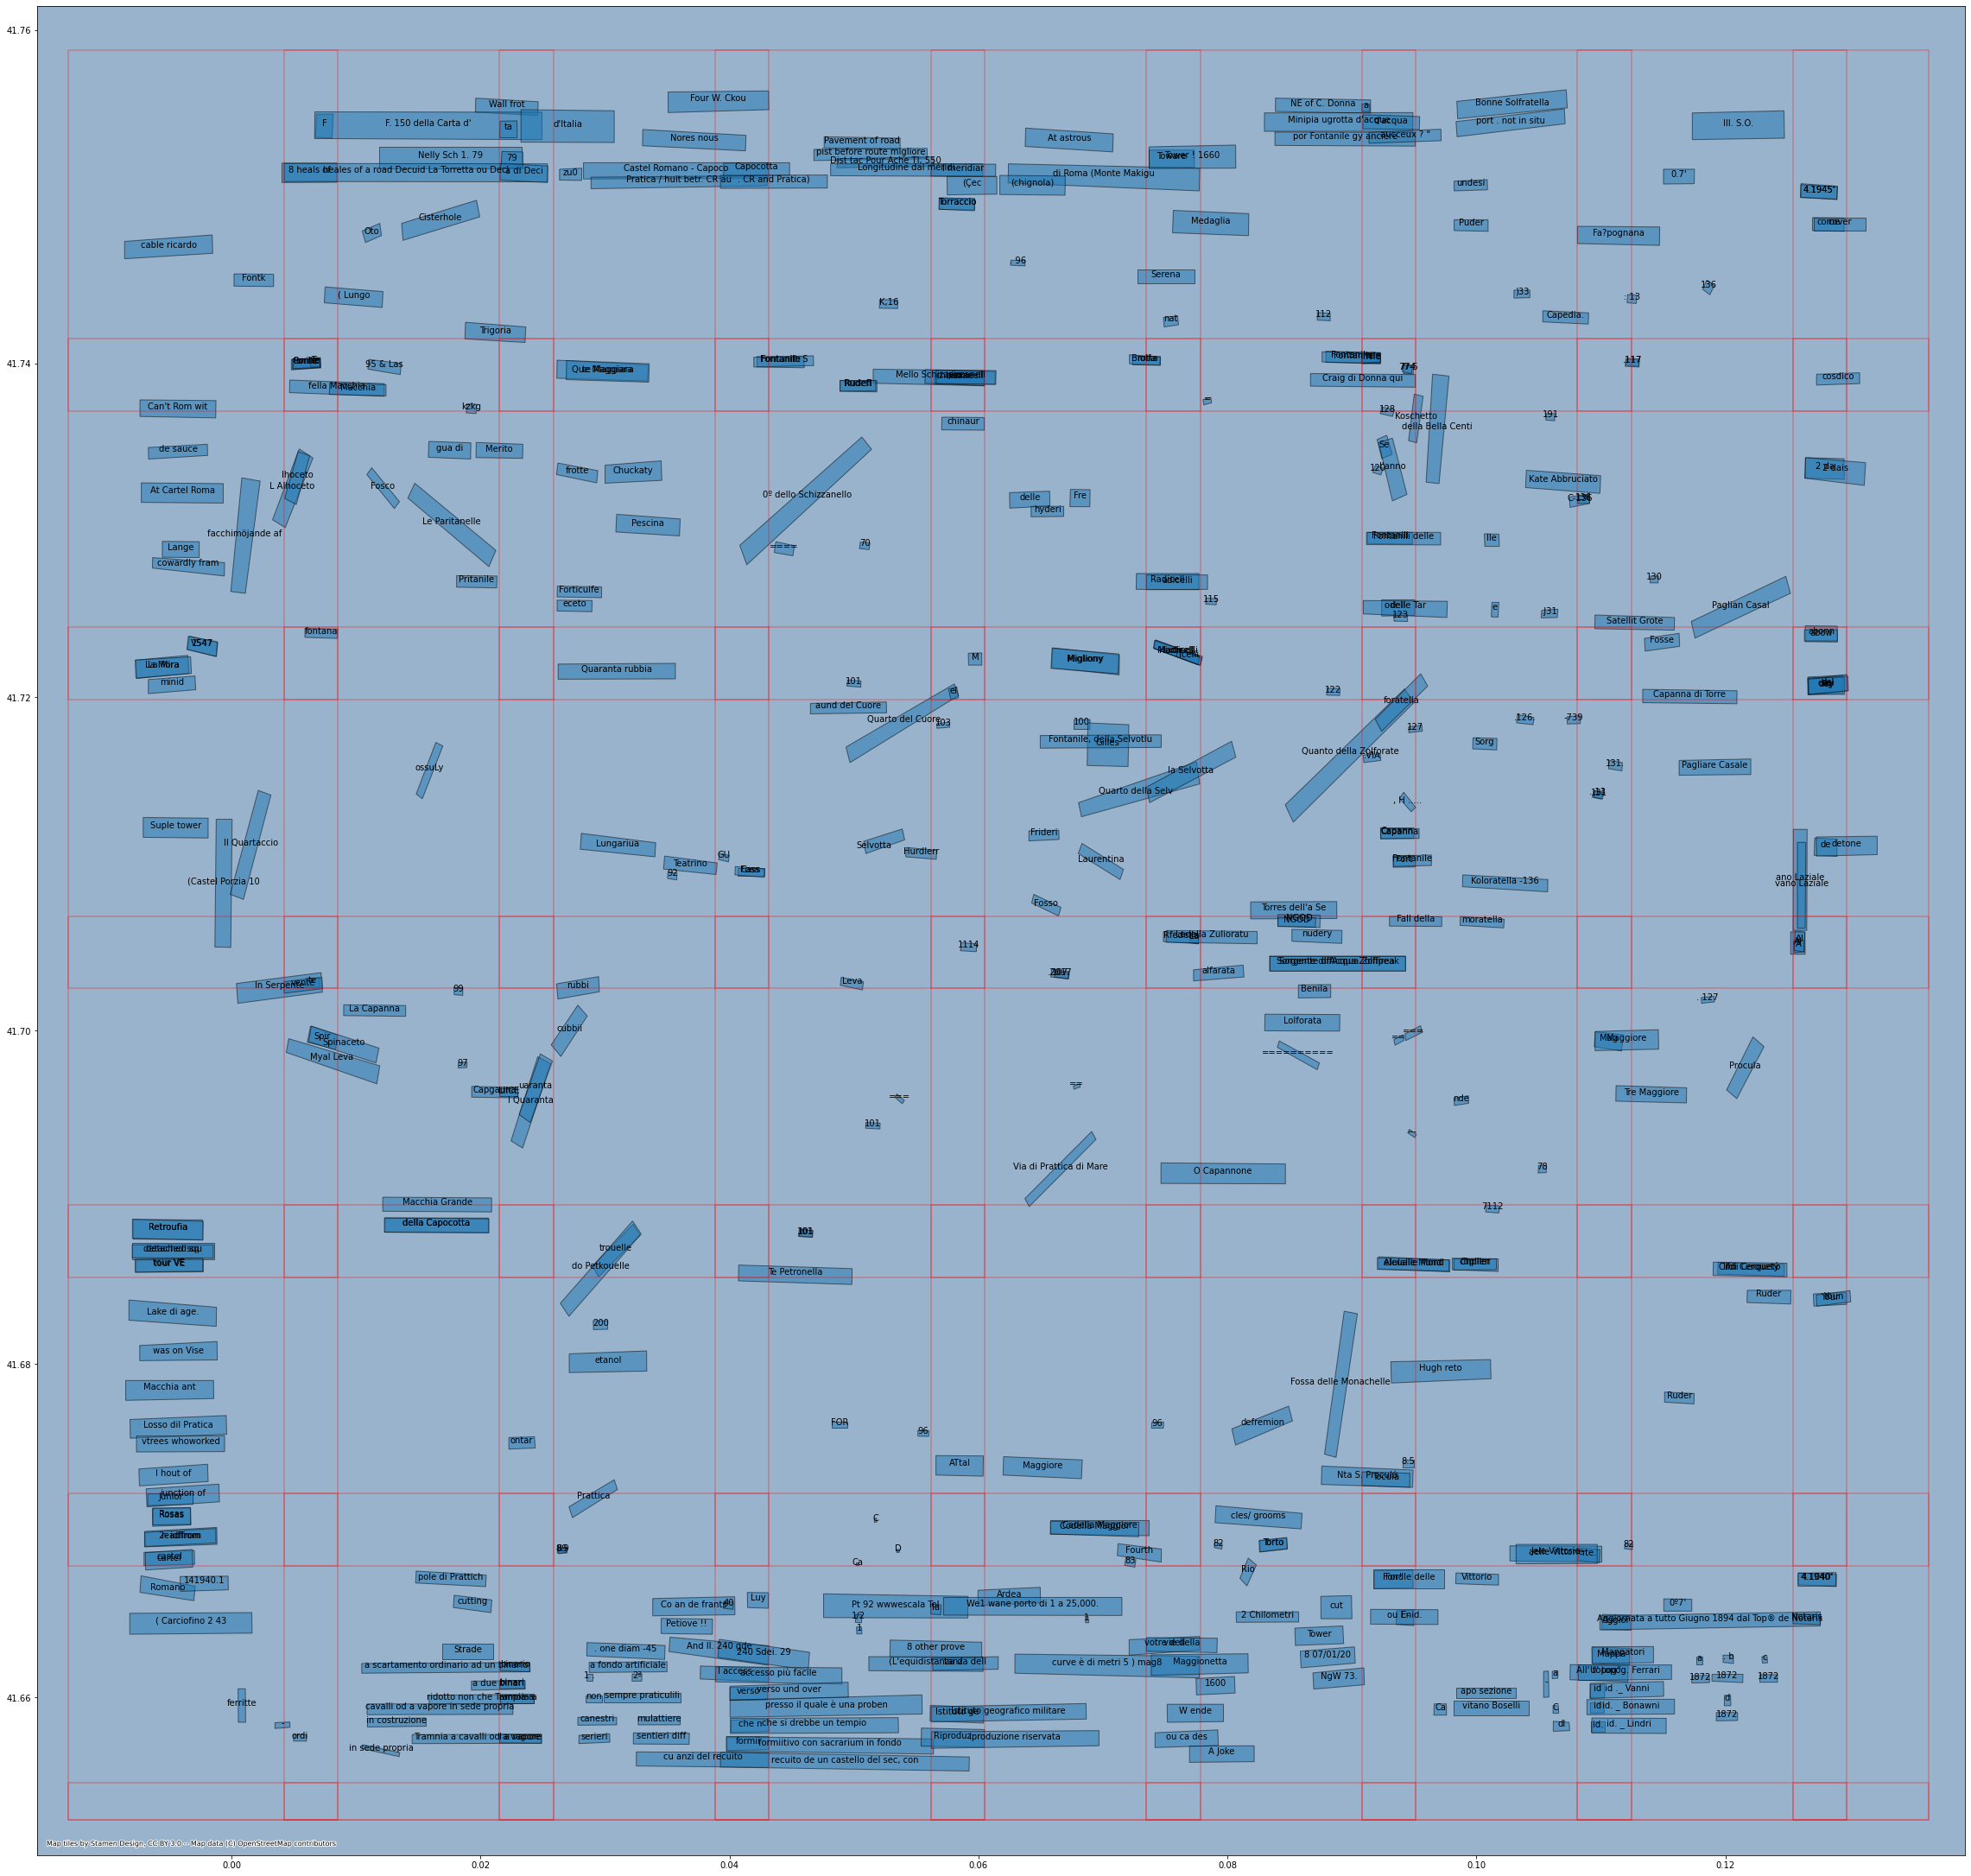

In [15]:
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text.shp"))

print(line_text_df.crs)
# Change crs to one compatible with basemap
line_text_df = line_text_df.to_crs(epsg=4806) #3857 #32129 (fix this)
print(line_text_df.crs)

ax = line_text_df.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

tile_polys_df=gpd.read_file(os.path.join(map_base_dir,"tif_tiles/tile_polys.shp"))

#tile_polys_df = tile_polys_df.to_crs(epsg=3857) #3857
tile_polys_df.boundary.plot(ax=ax,color="red",alpha=0.3)

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'], horizontalalignment='center')

In [16]:
glist = line_text_df['geometry']
tlist = line_text_df['text']
rows_to_remove = []
print(len(glist))
for i in range(len(glist)):
    for j in range(i + 1, len(glist)):
        intersect_poly = glist[i].intersection(glist[j])

        if(not intersect_poly.is_empty):
            if(glist[i].area < glist[j].area):
                # glist[i] is smaller
                if(intersect_poly.area/glist[i].area >.8):
                    print("remove i : ", i, j, "{:3.2%}".format(intersect_poly.area/glist[i].area), int(intersect_poly.area), " Remove: ", tlist[i], int(glist[i].area), " Keep: ", tlist[j], int(glist[j].area))
                    rows_to_remove.append(i)
            else:
                if(glist[i].area >= glist[j].area):  
                  if(intersect_poly.area/glist[j].area >.8):
                        print("remove j : ", i, j, "{:3.2%}".format(intersect_poly.area/glist[j].area), int(intersect_poly.area), " Keep: ", tlist[i], int(glist[i].area),  " Remove: ", tlist[j], int(glist[j].area))
                        rows_to_remove.append(j)
                    #else:             
                    #    print("keep both: ", i, j, "{:3.2%}".format(intersect_poly.area/glist[i].area), "{:3.2%}".format(intersect_poly.area/glist[j].area), int(intersect_poly.area), tlist[i], int(glist[i].area), tlist[j], int(glist[j].area))


448
remove i :  0 6 100.00% 0  Remove:  F 0  Keep:  F. 150 della Carta d' 0
remove i :  1 8 89.79% 0  Remove:  8 heals of 0  Keep:  heales of a road Decuid La Torretta ou Deci 0
remove j :  4 13 97.83% 0  Keep:  Porile 0  Remove:  Contle 0
remove j :  4 77 95.28% 0  Keep:  Porile 0  Remove:  Te 0
remove j :  4 89 100.00% 0  Keep:  Porile 0  Remove:  onile 0
remove j :  6 16 100.00% 0  Keep:  F. 150 della Carta d' 0  Remove:  ta 0
remove j :  7 20 95.67% 0  Keep:  Nelly Sch 1. 79 0  Remove:  79 0
remove j :  8 21 98.69% 0  Keep:  heales of a road Decuid La Torretta ou Deci 0  Remove:  à di Deci 0
remove j :  13 77 93.19% 0  Keep:  Contle 0  Remove:  Te 0
remove j :  13 89 100.00% 0  Keep:  Contle 0  Remove:  onile 0
remove j :  15 90 96.44% 0  Keep:  fella Macchia 0  Remove:  Macchia 0
remove j :  25 98 89.68% 0  Keep:  Que Maggiara 0  Remove:  te Maggiara 0
remove i :  32 43 97.89% 0  Remove:  Torraccio 0  Keep:  Torraccio 0
remove i :  34 105 89.02% 0  Remove:  Fontanile 0  Keep:  Fon

In [17]:
print(rows_to_remove)
# remove the rows
line_text_df_deduplicated = line_text_df
line_text_df_deduplicated = line_text_df_deduplicated.drop(rows_to_remove)
print(len(line_text_df_deduplicated['geometry']))
print(line_text_df_deduplicated['coords'],type(line_text_df_deduplicated['coords']))
print(line_text_df_deduplicated)
print(line_text_df_deduplicated.columns)

print(type(line_text_df_deduplicated))
#we have to drop this since .shp files don't support tuples
line_text_df_deduplicated = line_text_df_deduplicated.drop(columns='coords')
line_text_df_deduplicated.to_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))

print(line_text_df_deduplicated.columns)

[0, 1, 13, 77, 89, 16, 20, 21, 77, 89, 90, 98, 32, 34, 48, 106, 107, 38, 47, 48, 48, 57, 58, 66, 55, 134, 122, 66, 134, 75, 70, 74, 77, 96, 86, 87, 128, 119, 176, 190, 120, 134, 127, 130, 176, 190, 149, 148, 212, 157, 214, 220, 214, 220, 163, 163, 167, 178, 190, 187, 187, 248, 195, 196, 251, 253, 216, 220, 217, 222, 269, 275, 228, 224, 276, 277, 227, 240, 241, 289, 242, 296, 247, 262, 314, 315, 269, 274, 325, 326, 327, 288, 345, 385, 317, 312, 323, 318, 324, 323, 351, 355, 357, 364, 371, 360, 363, 367, 388, 380, 399, 402, 416, 417, 420, 422, 426, 428, 430, 447]
346
2      (-0.005058023447405678, 41.746969549905735)
3      (0.0017892839172641162, 41.744999715504406)
4       (0.005979491283378692, 41.739999366639495)
5         (0.02211114152907156, 41.75539005080812)
6        (0.01581075181412786, 41.754286077682096)
                          ...                     
442        (0.1124030618380199, 41.65944179823792)
443      (0.12017957841689103, 41.659820612545865)
444       (0.1122623

In [18]:
import rasterio
import rasterio.plot
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_df.crs)
# Change crs to one compatible with basemap
#line_text_df = line_text_df.to_crs(epsg=3857) #3857
#line_text_df = line_text_df.to_crs(epsg=32127) #3857

print(line_text_df.crs)

ax = line_text_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

for tf in tiles:
    tif_file = rasterio.open(tf)
    rasterio.plot.show(tif_file, ax=ax)
#ctx.add_basemap(ax)

tile_polys_df=gpd.read_file(os.path.join(map_base_dir,"tif_tiles/tile_polys.shp"))
#tile_polys_df = tile_polys_df.to_crs(epsg=3857) #3857
#tile_polys_df = tile_polys_df.to_crs(epsg=32637) #3857
tile_polys_df.boundary.plot(ax=ax,color="red",alpha=0.3)

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'],                 horizontalalignment='center')

Output hidden; open in https://colab.research.google.com to view.

In [19]:
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_df.crs)
# Change crs to one compatible with basemap
#line_text_df = line_text_df.to_crs(epsg=3857) #3857
#line_text_df = line_text_df.to_crs(epsg=4326) #3857
ax = line_text_df.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')
for tf in tiles:
    tif_file = rasterio.open(tf)
    rasterio.plot.show(tif_file, ax=ax)

line_text_df.boundary.plot(ax=ax,color="red",alpha=0.5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Remove all of the labels that have only numbers
import rasterio
import rasterio.plot

line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
rows_dedup_to_remove = []
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(" i : ", i, tlist_dedup[i])
    if(tlist_dedup[i].isnumeric()):
        rows_dedup_to_remove.append(i)
        print("remove i : ", i, tlist_dedup[i])
    if(len(tlist_dedup[i])==1):
        rows_dedup_to_remove.append(i)
        print("remove i : ", i, tlist_dedup[i])

print(rows_dedup_to_remove)
# remove the rows
line_text_df_no_nums = line_text_dedup_df
line_text_df_no_nums = line_text_dedup_df.drop(rows_dedup_to_remove)
print(len(line_text_df_no_nums['geometry']))

#print(line_text_df_no_nums['coords'],type(line_text_df_no_nums['coords']))
print(line_text_df_no_nums)
print(line_text_df_no_nums.columns)

print(type(line_text_df_no_nums))

line_text_df_no_nums.to_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))

print(line_text_df_deduplicated.columns)


line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(i, tlist_dedup[i])

In [ ]:
line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(i, tlist_dedup[i])

In [ ]:
import geopandas
line_text_df_search_file = os.path.join(map_base_dir,"all_line_text_search.shp")
shp_file = geopandas.read_file(line_text_df_search_file)
shp_file.to_file(os.path.join(map_base_dir,"all_line_text_search.geojson"), driver='GeoJSON')

Download /content/line_text.shp to use it in other maps such as ArcGIS Map. 